# Tutorial on Denrell, Fang, and Levinthal (2004)

In this tutorial, you will be introduced to a simple model that replicates the main finding from the paper by  
Jerker Denrell, Christina Fang, and Dan Levinthal, published in 2004 in Management Science.  

This tutorial provides a barebones description of the model. In the future I will incorporate it to the full_tutorial but this will require a large change to the initial model. 

**Reference:** Denrell, J., Fang, C., & Levinthal, D. A. (2004). From T-mazes to labyrinths: Learning from model-based feedback. Management Science, 50(10), 1366-1378.

# Basic Building Blocks

In this first sections, I will present the basic building blocks. Namely, the àgents, the organization, and the environment. The agents in this paper are both more complex but also simpler than the ones in Denrell and March (2001), or Posen and Levinthal (2012). They are simpler because they are "greedy", they always choose the best option available. Instead of using softmax, or aspiration level search. They are more complex because they are contextual. They choose according to the position in the labyrinth. 

## Agents
The agents follow perform few simple actions.  
### 1. Choose
The agents choose the best option available in the current position in the labyrinth. Each position has 11 different actions, as the there are 10 arms in the bandit combination. 
### 2. Jump
This function updates the position in the maze after a choice is made. It is done by flipping the position chosen. There are 11 positions, if the agent chooses 0, no position is flipped. A higher value flips the i'th value.  
### 3. Learn
This is problem solving part of the algorithm. It runs a simple for loop for num_periods of times. Each period the agent looks for a solution and updates the attractions of the agents as the simulation runs. The start of every period is different so the agent gets knowledge from the full labyrithn after a while.  
### 4. Reset
This function resets the starting point for the agent and the attractions of each position. In this paper, the agents are pesimists, having 0 expected value in the start. The agents are also greedy thus this is not problematic as it would be in softmax.  
### 5. Solve
This is the main function of the agent, the agent starts at a random point in the labyrinth and keeps choosing until the end point is reached. On every period the agent updates it beliefs of the attributes but only in the last does the agent get a feedback value. When the feedback value is received, the credit is backpropagated to the lambda states before the solution. To implement the creidt assignment we need to create a log of the choices and the states the agent passes through as the problem is solved. This provides a big difference with other bandits where states do not exists, so we just care about the choice in the current state.  
### 6. Staircase
This function is used for data output purposes only. The idea is to estimate the average mental model stair case shown in the paper. In this figure, the highest value at different Hamming distnaces are shown. 
### 2. Update
Updating is done via the Bush-Mossteller equation with the change. The parameter phi determines how much the agent updates its beliefs when faced with new information. A value of zero leads to agents to not update their beliefs. A value of one to full change of  their beliefs. A mixture leads to what is known as an Exponentially Recency Weighted Average (Sutton and Barto, 1998). The agents have a constant phi value, which allow them to be responsive to changes in the environment even in late stages.
The first change with the standard Sutton and Barto formula is the addition of a gamma parameter that links the current state's payoff with the payoff in the next state chosen. This is what is meant by credit assignment as when the problem is solve the credit is shared back to the prior positions in the solution. 
The second change is the inclusion of a multi-level credit assignment. The feedback in this case is not linked to the position behind the payoff but also to the lambda steps before.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

class agent:
    def __init__(self, phi, gamma, N, lamb):
        self.N = N
        self.phi = phi
        self.gamma = gamma
        self.lamb = lamb
    def choose(self): 
        val_max = np.max(self.attraction[self.state])
        max_choices = list([i for i in range(len(self.attraction[self.state])) if self.attraction[self.state][i] == val_max])
        if len(max_choices) > 1: return(np.random.choice(max_choices))
        else: return(max_choices[0])
    def jump(self, choice):
        next_state = list(self.state)
        if choice == 0: return(self.state)
        else:
            if self.state[choice-1] == '0': next_state[choice-1] = '1'
            elif self.state[choice-1] == '1': next_state[choice-1] = '0'
            next_state = "".join(next_state)
            return(next_state)
    def learn(self, bandits, num_periods):
        log_k = []
        for i in range(num_periods): 
            self.state = int2pol(np.random.choice(range(2**self.N)), self.N)
            log_k.append(self.solve(bandits))
        mental_model = self.staircase()
        return([log_k, mental_model])
    def reset(self, start_state = []):
        self.attraction = {int2pol(i,self.N): np.zeros(self.N+1) for i in range(2**self.N)}
        if start_state == []: self.state = int2pol(np.random.choice(range(2**self.N)), self.N)
        else: self.state = start_state
    def solve(self, bandits):
        payoff = 0.0
        k = 0
        log_state = []
        log_choice = []
        while payoff == 0.0 and k< 10000:
            log_state.append(self.state)
            choice = self.choose()
            next_state = self.jump(choice)
            payoff = bandits.measure(next_state)
            self.state = next_state
            log_choice.append(choice)
            self.update(log_state, log_choice, next_state, payoff)
            k+=1
        log_state.append(next_state)
        log_choice.append(0)
        self.update(log_state, log_choice, next_state, payoff)
        return(k)
    def update(self, log_state, log_choice, next_state, payoff):
        log_state.reverse()
        log_choice.reverse()
        self.attraction[log_state[0]][log_choice[0]] = (self.attraction[log_state[0]][log_choice[0]]*(1-self.phi) 
                                                      + self.phi*(payoff+self.gamma*np.max(self.attraction[next_state])))
        if len(log_state) > 1 and self.lamb > 1: 
            next_state = log_state[0]
            if len(log_state) > self.lamb: depth = range(self.lamb-1)
            else: depth = range(len(log_state)-1)
            for i in depth:
                self.attraction[log_state[i+1]][log_choice[i+1]] = (self.attraction[log_state[i]][log_choice[i]]*(1-self.phi) 
                                                       + self.phi*self.gamma*np.max(self.attraction[next_state]))
                next_state = log_state[i]
    def staircase(self):
        d = {"policies": [key for key in self.attraction.keys()],
             "values": [np.max(val) for val in self.attraction.values()],
             "distance": hamming(self.attraction.keys(), "0"*10)}
        db = pd.DataFrame(d)
        mental_model = [np.mean(db.loc[db.distance == i, "values"]) for i in range(11)]
        return(mental_model)

## Miscellaneous Functions

I have two miscellaneous functions.

### int2pol
This function is take from the NK tutorial, it translates an integer from to a string of N binary characters. This allows me to create a simple dictionary for each state in the maze. 

### hamming
This function measures the hamming distance of a policy to the winning state.

In [2]:
def int2pol(pol_int, n):
    pol = bin(pol_int)[2:] # removes the '0b'
    if len(pol) < n: pol = '0'*(n-len(pol)) + pol
    return(pol)      
def hamming(policies, bingo):
    hamming = [np.sum([1 if pol[j] != bingo[j] else 0 for j in range(len(bingo))]) for pol in policies]
    return(hamming)

## Environment
In this paper, the bandits are specially simple. There is no noise due to the bandit. Thus the bandits just output the mean value for which they are initialized. However, there are many 2^N bandits instead of just 10. This is similar to a typical description of rugged landscape where N variables produce 2^N positions in the landscape.  

### 1. Bandit
The bandit is a simple structure. It has a mean and it outputs it when measured.

#### Measure
The bandits perform one function, when called upon, they give the mean of the bandit. 

In [3]:
class bandit:
    def __init__(self, mean): self.mean = mean
    def measure(self): return(self.mean)

###  2. Bandits_DFL
This class creates the environment for the Denrell, Fang, and Levinthal (2004) paper. In specific, 2^N bandits where 2^N - 1 have zero value and one has a value of 1. 

#### Make Bandit
Although Jerker, Christina, and Dan study 2^N positions in a labyrinth, these positions just output two values, a minimum and a maximum. The maximum is given when both agents choose the correct state (bingo). The minimum is given in every other state pair. Because of this, we can simplify the environment and create just two bandits. One for when the high value is reached, another one for every other state. This is the same we did for Puranam and Swamy (2016). However, there we had just M^2 bandits. 

#### Measure
This function routes which bandit will give the output. If both choices are correct, then we measure the high-valued bandit. In every other case, we choose the other bandit. 

In [4]:
class bandits_P_S:
    def __init__(self, bingo, val_max, val_min): 
        self.arms = [bandit(mean = val_max), bandit(mean = val_min)]
        self.bingo = bingo
    def measure(self, choice): 
        if choice == self.bingo: return(self.arms[0].measure())
        else: return(self.arms[1].measure())

# Simulation

With the previous three building blocks, we can run a simulation to replicate the main findings of Denrell, Fang, and Levinthal (2004).

## 1. Initialize values
The first thin we need to do is initialize each module. That is, set how the agents learn, and how the environment is built.  

### 1.1 Bandit
We start by specifying the bandits. There are ten bandits. The bandits have a maximum value that appears when both agents choose option 2 (bingo!). If not then a minimum value is given. The maximum value 1 and the minimum value is 0.

In [5]:
num_bandits = 10
val_max = 1.0
val_min = 0.0
bingo = "0"*num_bandits

### 1.2 Agents  
The agents are fully specified by three parameters. phi, gamma, and lambda. Note that in Python lambda is already used, so I call it lamb instead.    
  
* Phi specifies how much they update their beliefs.
* Gamma specifcies how the credit is assigned and how linked the action-state pairs are
* Lambda specifices the number of levels back that a credit assignment is shared

In [6]:
phi = 0.25 # not needed in "over k" updating mode
gamma = 0.8
lamb = 1

### 1.3 Simulation
In the paper, the simulation is run for 100 periods and 1000 replications. Here I run just 200 replications. The simulation is stable so taking longer time is not needed.   
Please note, that just as in the paper, I start from a random place in the labyrinth on every ocassion. The authors change it in some of their analysis, I do not do it but I leave the provision for a future change in the simulation. 

In [7]:
num_periods = 100
num_reps = 200 # 1000 typical
start_state = [] # random

## 2. Initialize agent, organization, and bandits
We can now initialize the agents, organization, and bandtis based upon the prior values. 

In [8]:
Alice = agent(phi = phi, gamma = gamma, N = num_bandits, lamb = lamb)
Labyrinth = bandits_P_S(bingo = bingo, val_min = val_min, val_max = val_max)

## 3. Run simulation
The simulation asks the agents to learn for 30 periods for 200 times. It stores two main values, the number of steps taken on average on every period to reach the exit of the labyrinth and the maximum beliefs at each Hamming distance. 

In [9]:
def run_simulation(Firms, options, num_periods, num_reps, start_state):
    log_epochs = []
    log_mental = []
    for i in range(num_reps):
        Firms.reset(start_state)
        log_k, mental = Firms.learn(options, num_periods)
        log_epochs.append(log_k)
        log_mental.append(mental)
        if i%10 == 0: print(int(i/10), end = ".")
    k_period = [np.mean([log_epochs[k][j] for k in range(num_reps)]) for j in range(num_periods)]
    mental_model = [np.mean([log_mental[k][j+1] for k in range(num_reps)]) for j in range(10)]
    return([k_period, mental_model])

## 4. Run
We run four simulations to replicate Figures 2 and 4 of the paper. We have a case where the agent has high credit assignment strength (gamma) but just one leavel of back propagation. Then a case where the credit assinment is null and short. Then two cases with high strength and 5-levels of back propagation, and 30 levels respectively. Again, just replicating Figures 2 and 4 in the paper. 

In [10]:
t = time()
Alice.gamma = 0.9
Alice.lamb = 1
length1, m1 = run_simulation(Alice, Labyrinth, num_periods, num_reps, start_state)
print("First simulation done. It took: " + str(round(time()-t)) + " seconds.")
Alice.gamma = 0.0
Alice.lamb = 1
length2, m2 = run_simulation(Alice, Labyrinth, num_periods, num_reps, start_state)
print("Second simulation done. Total time so far: " + str(round(time()-t)) + " seconds.")
Alice.gamma = 0.9
Alice.lamb = 5
length3, m3 = run_simulation(Alice, Labyrinth, num_periods, num_reps, start_state)
print("Third simulation done. Total time so far: " + str(round(time()-t)) + " seconds.")
Alice.gamma = 0.9
Alice.lamb = 30
length4, m4 = run_simulation(Alice, Labyrinth, num_periods, num_reps, start_state)
print("Final simulation done. Total time: " + str(round(time()-t)) + " seconds.")

0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.First simulation done. It took: 75 seconds.
0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.Second simulation done. Total time so far: 272 seconds.
0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.Third simulation done. Total time so far: 325 seconds.
0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.Final simulation done. Total time: 510 seconds.


## 4.  Display results
I first plot the results of Figure 1 in the paper, where the mental models are shown. The values here are higher than 1. I guess I have a bug, but not sure where.

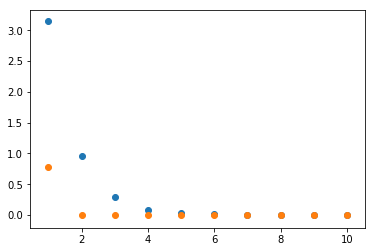

In [11]:
plt.scatter(range(1, num_bandits+1), m1)
plt.scatter(range(1, num_bandits+1), m2)

I now present the results of replicating the Figures 2 and 4 of the Denrell, Fang, and Levinthal (2004) paper. We merge the two figures into one. The orange dots are from Figure 3, the green and red from Figure 4. The blue dots are in both figures. 

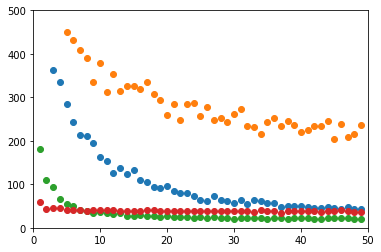

In [13]:
plt.scatter(range(50), length1[:50])
plt.scatter(range(50), length2[:50])
plt.scatter(range(50), length3[:50])
plt.scatter(range(50), length4[:50])
plt.axis((0,50,0,500))
plt.show()

## 5. Exercise
What would happen if instead of starting all beliefs at zero we started them at 0.5? or a random value?

## 6. Question
Should one update the value at the end? After exit? It is unclear to me, but the simulation changes a lot if it is not done.  